In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [10]:
#Returns a numpy array with size nrows x ncolumns-1. nrows and ncolums are the rows and columns of the dataset
#the Date column is skipped (ncolumns-1)
def readData(fname):
    with open(fname) as f:
        fileData = f.read()
  
    lines = fileData.split("\n")
    header = lines[0].split(",")
    lines = lines[1:] 
    #print(header) 
    #print("Data rows: ", len(lines))

    rawData = np.zeros((len(lines), len(header)-1)) #skip the Date column

    for i, aLine in enumerate(lines):       
        splittedLine = aLine.split(",")[:]
        rawData[i, 0] = splittedLine[0]
        rawData[i, 1:] = [float(x) for x in splittedLine[2:]] 

    return rawData

In [11]:
#Returns the train and test data, normalized. It also returns the standard deviation of Weekly_Sales
#Each list has a size equal to the number of stores
#For each store there is a list of size trainNSamples (testNSamples) x nColums-1 (the store id is skipped)
#Columns: Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
def splitTrainTest(rawData, testPercent):

    listStore = np.unique(rawData[:, 0])
    trainNSamples = np.zeros(len(listStore))
    
    for i, storeId in enumerate(listStore):
        trainNSamples[i] = np.count_nonzero(rawData[:, 0] == storeId)
    trainNSamples = np.floor((1-testPercent) *  trainNSamples)

    tmpTrain = np.zeros((int(np.sum(trainNSamples)), len(rawData[0])))

    store = -1
    counter = 0
    counterTrain = 0
    storeDict = dict(zip(listStore, trainNSamples))
    for i, aLine in enumerate(rawData):
        if store != aLine[0]:
            store = int(aLine[0])
            counter = 0
        if(counter < storeDict.get(store)):
            tmpTrain[counterTrain] = rawData[i][:]
            counterTrain += 1
            counter += 1

    meanData = tmpTrain.mean(axis=0)
    stdData = tmpTrain.std(axis=0)
    rawNormData = (rawData - meanData) / stdData

    allTrain = list()
    allTest = list()
    store = -1
    counter = 0
    for i, aLine in enumerate(rawNormData):
        splittedLine = [float(x) for x in aLine[1:]] #skip store id
        if store != rawData[i][0]:
            if i != 0:
                allTrain.append(storeDataTrain)
                allTest.append(storeDataTest)
            store = int(rawData[i][0])
            storeDataTrain = list()
            storeDataTest = list()
            counter = 0

        if(counter < storeDict.get(store)):
            storeDataTrain.append(splittedLine)
            counter += 1
        else:
            storeDataTest.append(splittedLine)

        if i == len(rawNormData)-1:
            allTrain.append(storeDataTrain)
            allTest.append(storeDataTest)

    return allTrain, allTest, stdData[1] #std of wSales

In [12]:
#generates a time series given the input and ouput data, the sequence length and the batch size
#seqLength is the number of weeks (observations) of data to be used as input
#the target will be the weekly sales in 2 weeks
def generateTimeSeries(data, wSales, seqLength, batchSize):   
    sampling_rate = 1 #keep all the data points 
    weeksInAdvance = 3
    delay = sampling_rate * (seqLength + weeksInAdvance - 1) #the target will be the weekly sales in 2 weeks
    
    dataset = keras.utils.timeseries_dataset_from_array(
        data[:-delay],
        targets=wSales[delay:],
        sampling_rate=sampling_rate,
        sequence_length=seqLength,
        shuffle=True,
        batch_size=batchSize,
        start_index=0)
    
    return dataset


In [13]:
def printTimeSeriesList(theList):
    print('list length', len(theList))
    print('First element')
    input, target = theList[0]
    print([float(x) for x in input.numpy().flatten()], [float(x) for x in target.numpy().flatten()])
    print('Last element')
    input, target = theList[-1]
    print([float(x) for x in input.numpy().flatten()], [float(x) for x in target.numpy().flatten()])

In [14]:
#returns the training and test time series
#it also returns the standard deviation of Weekly_Sales, and the number of input features
def generateTrainTestData(fileName, testPercent, seqLength, batchSize):
    rawData = readData(os.path.join(fileName))
    allTrain, allTest, stdSales = splitTrainTest(rawData, testPercent)
    
    for i in range(len(allTrain)):
        tmp_train = generateTimeSeries(np.array(allTrain[i]), np.array(allTrain[i])[:,0], seqLength, batchSize)
        tmp_test = generateTimeSeries(np.array(allTest[i]), np.array(allTest[i])[:,0], seqLength, batchSize)

        if i == 0:
            train_dataset = tmp_train
            test_dataset = tmp_test
        else:
            train_dataset = train_dataset.concatenate(tmp_train)
            test_dataset = test_dataset.concatenate(tmp_test)
    
    return train_dataset, test_dataset, stdSales, np.shape(allTrain)[2]

In [15]:
#generateTrainTestData(fileName, testPercent, seqLength, batchSize):
#trainData, testData: each element comes from keras.utils.timeseries_dataset_from_array, i.e., is a time series
#Columns: Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment

testPercent = 0.2
seqLength = 8
batchSize = 1
trainData, testData, stdSales, nFeatures = generateTrainTestData("data/walmart-sales-dataset-of-45stores.csv",
    testPercent, seqLength, batchSize) 

# Basic RNN

In [39]:
inputs = keras.Input(shape=(seqLength, 6))

x = layers.SimpleRNN(16)(inputs)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("walmart_basic_rnn.keras", save_best_only=True, monitor="val_loss")
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

#print the model summary
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 8, 6)]            0         
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 16)                368       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


In [44]:
history = model.fit(trainData,
                    epochs=10,
                    validation_data=testData,
                    callbacks=callbacks)

#model = keras.models.load_model("walmart_basic_rnn.keras") 
#print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
4365/4365 [==============================] - 33s 7ms/step - loss: 0.0407 - mae: 0.1331 - val_loss: 0.0622 - val_mae: 0.1959
Epoch 2/10
4365/4365 [==============================] - 36s 8ms/step - loss: 0.0409 - mae: 0.1326 - val_loss: 0.0603 - val_mae: 0.1948
Epoch 3/10
4365/4365 [==============================] - 45s 10ms/step - loss: 0.0400 - mae: 0.1312 - val_loss: 0.0593 - val_mae: 0.1917
Epoch 4/10
4365/4365 [==============================] - 39s 9ms/step - loss: 0.0392 - mae: 0.1303 - val_loss: 0.0478 - val_mae: 0.1720
Epoch 5/10
4365/4365 [==============================] - 43s 10ms/step - loss: 0.0389 - mae: 0.1287 - val_loss: 0.0442 - val_mae: 0.1641
Epoch 6/10
4365/4365 [==============================] - 39s 9ms/step - loss: 0.0387 - mae: 0.1293 - val_loss: 0.0464 - val_mae: 0.1730
Epoch 7/10
4365/4365 [==============================] - 43s 10ms/step - loss: 0.0388 - mae: 0.1289 - val_loss: 0.0463 - val_mae: 0.1722
Epoch 8/10
4365/4365 [==============================

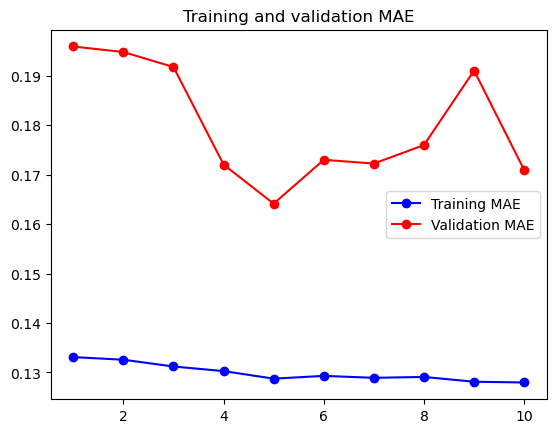

Lowest validation MAE:  93845.06268896589


In [52]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "b-o", label="Training MAE")
plt.plot(epochs, val_loss, "r-o", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

print("Lowest validation MAE: ", min(val_loss) * stdSales)

# Recurrent Dropout

In [54]:
inputs = keras.Input(shape=(seqLength, 6))

x = layers.LSTM(32, recurrent_dropout=0.10)(inputs)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("walmart_recurrent_rnn.keras", save_best_only=True, monitor="val_loss")
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

#print the model summary
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 8, 6)]            0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                4992      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


In [55]:
history = model.fit(trainData,
                    epochs=10,
                    validation_data=testData,
                    callbacks=callbacks)

Epoch 1/10
4365/4365 [==============================] - 45s 10ms/step - loss: 0.1378 - mae: 0.2369 - val_loss: 0.2208 - val_mae: 0.3688
Epoch 2/10
4365/4365 [==============================] - 59s 13ms/step - loss: 0.0987 - mae: 0.2005 - val_loss: 0.1454 - val_mae: 0.2929
Epoch 3/10
4365/4365 [==============================] - 63s 14ms/step - loss: 0.0889 - mae: 0.1929 - val_loss: 0.1852 - val_mae: 0.3342
Epoch 4/10
4365/4365 [==============================] - 79s 18ms/step - loss: 0.0846 - mae: 0.1882 - val_loss: 0.2024 - val_mae: 0.3411
Epoch 5/10
4365/4365 [==============================] - 88s 20ms/step - loss: 0.0751 - mae: 0.1790 - val_loss: 0.1428 - val_mae: 0.2778
Epoch 6/10
4365/4365 [==============================] - 93s 21ms/step - loss: 0.0687 - mae: 0.1744 - val_loss: 0.1284 - val_mae: 0.2623
Epoch 7/10
4365/4365 [==============================] - 80s 18ms/step - loss: 0.0627 - mae: 0.1698 - val_loss: 0.1077 - val_mae: 0.2381
Epoch 8/10
4365/4365 [==========================

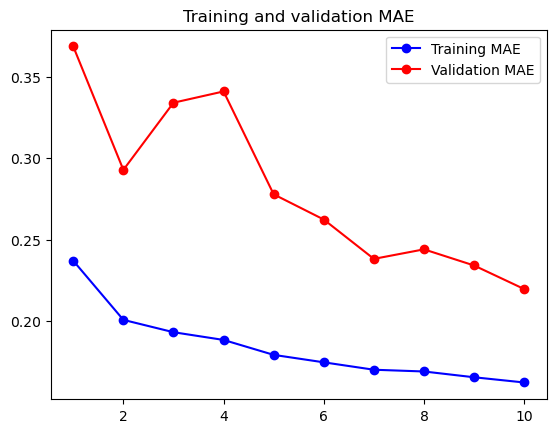

Lowest validation MAE:  125524.5131862228


In [56]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "b-o", label="Training MAE")
plt.plot(epochs, val_loss, "r-o", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

print("Lowest validation MAE: ", min(val_loss) * stdSales)

# Stacking Recurrent Layers

In [57]:
inputs = keras.Input(shape=(seqLength, 6))

x = layers.GRU(32, recurrent_dropout=0.2, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.2)(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("walmart_stacked_rnn.keras", save_best_only=True, monitor="val_loss")
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

#print the model summary
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 8, 6)]            0         
                                                                 
 gru_4 (GRU)                 (None, 8, 32)             3840      
                                                                 
 gru_5 (GRU)                 (None, 32)                6336      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 10,209
Trainable params: 10,209
Non-trainable params: 0
_________________________________________________________________


In [58]:
history = model.fit(trainData,
                    epochs=10,
                    validation_data=testData,
                    callbacks=callbacks)

Epoch 1/10
4365/4365 [==============================] - 179s 40ms/step - loss: 0.1360 - mae: 0.2377 - val_loss: 0.1886 - val_mae: 0.3423
Epoch 2/10
4365/4365 [==============================] - 206s 47ms/step - loss: 0.0832 - mae: 0.1884 - val_loss: 0.1020 - val_mae: 0.2413
Epoch 3/10
4365/4365 [==============================] - 211s 48ms/step - loss: 0.0661 - mae: 0.1732 - val_loss: 0.0814 - val_mae: 0.2154
Epoch 4/10
4365/4365 [==============================] - 177s 41ms/step - loss: 0.0623 - mae: 0.1661 - val_loss: 0.0790 - val_mae: 0.2025
Epoch 5/10
4365/4365 [==============================] - 205s 47ms/step - loss: 0.0602 - mae: 0.1638 - val_loss: 0.0986 - val_mae: 0.2347
Epoch 6/10
4365/4365 [==============================] - 182s 42ms/step - loss: 0.0579 - mae: 0.1611 - val_loss: 0.0731 - val_mae: 0.1925
Epoch 7/10
4365/4365 [==============================] - 213s 49ms/step - loss: 0.0546 - mae: 0.1583 - val_loss: 0.0680 - val_mae: 0.1802
Epoch 8/10
4365/4365 [===================

KeyboardInterrupt: 

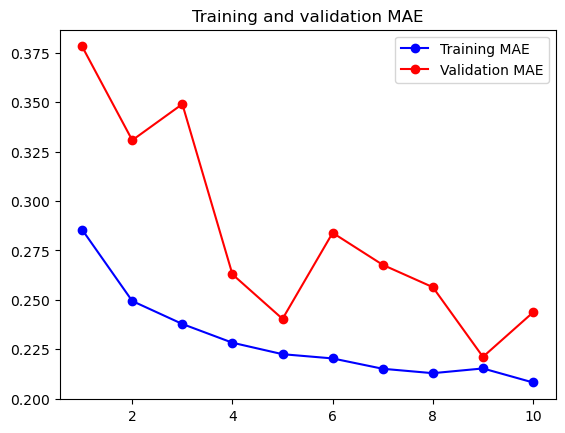

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "b-o", label="Training MAE")
plt.plot(epochs, val_loss, "r-o", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

print("Lowest validation MAE: ", min(val_loss) * stdSales)

# Bidirectional RNNs

In [ ]:
inputs = keras.Input(shape=(seqLength, 6))

x = layers.Bidirectional(layers.LSTM(32))(inputs)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("walmart_bidirectional_rnn.keras", save_best_only=True, monitor="val_loss")
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

#print the model summary
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 8, 6)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 32)               2944      
 l)                                                              
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,977
Trainable params: 2,977
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(trainData,
                    epochs=10,
                    validation_data=testData,
                    callbacks=callbacks)

Epoch 1/10
4365/4365 [==============================] - 56s 12ms/step - loss: 0.1292 - mae: 0.2073 - val_loss: 0.2457 - val_mae: 0.3770
Epoch 2/10
4365/4365 [==============================] - 43s 10ms/step - loss: 0.0892 - mae: 0.1756 - val_loss: 0.1560 - val_mae: 0.2974
Epoch 3/10
4365/4365 [==============================] - 52s 12ms/step - loss: 0.0731 - mae: 0.1588 - val_loss: 0.1185 - val_mae: 0.2689
Epoch 4/10
4365/4365 [==============================] - 54s 12ms/step - loss: 0.0632 - mae: 0.1505 - val_loss: 0.0738 - val_mae: 0.2219
Epoch 5/10
4365/4365 [==============================] - 54s 12ms/step - loss: 0.0566 - mae: 0.1434 - val_loss: 0.0563 - val_mae: 0.1947
Epoch 6/10
4365/4365 [==============================] - 55s 13ms/step - loss: 0.0511 - mae: 0.1382 - val_loss: 0.0483 - val_mae: 0.1780
Epoch 7/10
4365/4365 [==============================] - 56s 13ms/step - loss: 0.0454 - mae: 0.1332 - val_loss: 0.0412 - val_mae: 0.1597
Epoch 8/10
4365/4365 [==========================

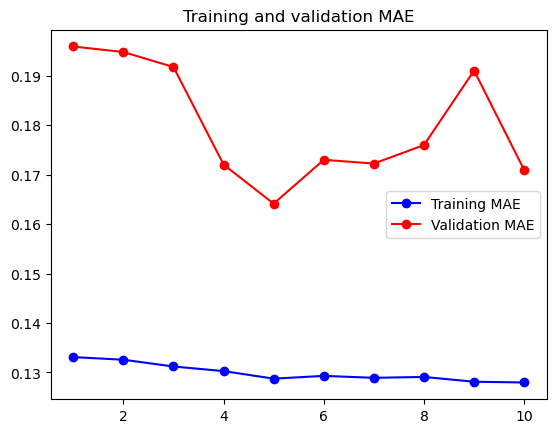

Lowest validation MAE:  93845.06268896589


In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "b-o", label="Training MAE")
plt.plot(epochs, val_loss, "r-o", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

print("Lowest validation MAE: ", min(val_loss) * stdSales)